Lingjie is working on a dataset of 1817 NCLDV genomes, and so I decided to have a look at the
ANI distribution of these genomes and compare it to the tree he's built.

I ran `fastANI` with a fragment length of 3000 and $k$-mer length of 16, and `CheckV` v1.0.1 with
the default database and parameters

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

import pandas
import seaborn
import gzip
from Bio import SeqIO
import pyprind
from SuchTree import SuchTree
from Bio.SeqIO import parse
from Bio.SeqUtils import GC
from io import BufferedReader, TextIOWrapper
import tarfile
from os import path
from itertools import combinations
from collections import defaultdict

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# dataset properties

fraglength = 3000  # fastANI fragment length 
kmer       = 16    # fastANI k-mer length
min_aln    = 10    # minimum number of aligned fragments
max_ani    = 100 # maximum ANI threshold

In [3]:
header = ['query', 'reference', 'ANI', 'bidirectional fragment mappings', 'total query fragments' ]
fastani = pandas.read_csv( 'data/lingjie/lingjie_ncldvs_vs_ncldvs_fastani.txt', sep='\t', names=header )

# drop self-hits
fastani = fastani[ fastani['query'] != fastani['reference'] ]

# de-duplicate (i.e., take the lower triangle of the matrix)
fastani['hash'] = fastani.apply( lambda row : hash( tuple( sorted( ( row['query'], row['reference'] ) ) ) ), axis=1 )
fastani.drop_duplicates( subset='hash', keep='first', inplace=True )
fastani.drop( ['hash'], axis=1, inplace=True )

fastani['query']     = [ q[15:-3] for q in fastani['query'] ]
fastani['reference'] = [ r[15:-3] for r in fastani['reference'] ]

def tarball_fasta_summary( tarball ) :
    '''
    Summarize the FASTA files in a tarball.
    '''
    tb = tarfile.open( tarball, 'r' )
    data = {}
    for name in tb.getnames() :
        f = tb.extractfile( name )
        if name.endswith( '.fa' ) :
            taxon = path.split( name )[-1][:-3]
            data[taxon] = { 'contigs' : 0, 'size' : 0, 'G+C' : 0 }
            sizes = []
            gcs   = []
            for n,rec in enumerate( SeqIO.parse( TextIOWrapper(f), 'fasta' ) ) :
                sizes.append( len(rec) )
                gcs.append(   GC(rec.seq)  )
            data[taxon]['contigs']      = len(sizes)
            data[taxon]['size']         = sum(sizes)
            data[taxon]['G+C']          = mean(gcs)
    return data

# add sequence statistic ANI table
seqsummary = tarball_fasta_summary( 'data/lingjie/lingjie_ncldvs.tar.gz' )

fastani['query_contigs'] = [ seqsummary[x]['contigs'] for x in fastani['query'] ]
fastani['query_size']    = [ seqsummary[x]['size'] for x in fastani['query'] ]
fastani['query_G+C']     = [ seqsummary[x]['G+C'] for x in fastani['query'] ]

fastani['reference_contigs'] = [ seqsummary[x]['contigs'] for x in fastani['reference'] ]
fastani['reference_size']    = [ seqsummary[x]['size'] for x in fastani['reference'] ]
fastani['reference_G+C']     = [ seqsummary[x]['G+C'] for x in fastani['reference'] ]

fastani['size_deviation'] = [ abs( row['query_size'] - row['reference_size'] )
                               / ( row['query_size'] + row['reference_size'] ) for n,row in fastani.iterrows() ]

fastani['G+C_deviation']  = [ abs( row['query_G+C'] - row['reference_G+C'] ) for n,row in fastani.iterrows() ]

# compute phylogenetic distances between each ANI pair
T = SuchTree( 'data/lingjie/Mixture.Conca4.2ndRound.treefile' )

fastani['treedist'] = fastani[ ( fastani['query'].isin( T.leafs ) ) 
                             & ( fastani['reference'].isin( T.leafs ) ) ].apply(
                                    lambda row : T.distance( row['query'], row['reference'] ), axis=1 )

# merge metadata
md_cols = [ 'Final_names',
            'Source',
            'Status',
            'Realm',
            'Phylum',
            'Class',
            'Order',
            'Family_Linking_to_GVDB',
            'Family_manual',
            'Subfamily_manual',
            'Genus_manual',
            'N50' ]

raw_metadata = pandas.read_csv( 'data/lingjie/general_metadata.csv' )
metadata = raw_metadata[ md_cols ]

fastani = pandas.merge( fastani, metadata, how='left', left_on='query', right_on='Final_names' )
fastani.rename( columns={ c : 'query_' + c.lower() for c in md_cols }, inplace=True )

fastani = pandas.merge( fastani, metadata, how='left', left_on='reference', right_on='Final_names' )
fastani.rename( columns={ c : 'reference_' + c.lower() for c in md_cols }, inplace=True )

# merge CheckV results
checkv = pandas.read_csv( 'data/lingjie/checkv_output/quality_summary.tsv', sep='\t' )

fastani = pandas.merge( fastani, checkv, how='left', left_on='query', right_on='contig_id' )
fastani.rename( columns={ c : 'query_' + c for c in checkv.columns }, inplace=True )

fastani = pandas.merge( fastani, checkv, how='left', left_on='reference', right_on='contig_id' )
fastani.rename( columns={ c : 'reference_' + c for c in checkv.columns }, inplace=True )

fastani

/home/russell/opt/lib/python3.10/site-packages/Bio/SeqUtils/__init__.py:144: BiopythonDeprecationWarning: GC is deprecated; please use gc_fraction instead.
  warnings.warn(


,query,reference,ANI,bidirectional fragment mappings,total query fragments,query_contigs,query_size,query_G+C,reference_contigs,reference_size,...,reference_gene_count,reference_viral_genes,reference_host_genes,reference_checkv_quality,reference_miuvig_quality,reference_completeness,reference_completeness_method,reference_contamination,reference_kmer_freq,reference_warnings
0,Ascoviridae_EF133465_Heliothis_virescens_ascov...,Ascoviridae_KJ755191_Heliothis_virescens_ascov...,92.6268,59,62,1,186262,45.874628,1,198157,...,190,84,1,High-quality,High-quality,99.64,AAI-based (high-confidence),0.0,1.01,NaN
1,Asfarviridae_AM712240_African_swine_fever_viru...,Asfarviridae_AY261362_African_swine_fever_viru...,98.3171,57,57,1,171719,38.865239,1,192714,...,173,76,1,Complete,High-quality,100.00,ITR (high-confidence),0.0,1.02,NaN
2,Asfarviridae_AM712240_African_swine_fever_viru...,Asfarviridae_MG939588_UNVERIFIED_African_swine...,97.4336,57,57,1,171719,38.865239,1,189401,...,169,71,1,High-quality,High-quality,99.03,AAI-based (high-confidence),0.0,1.01,NaN
3,Asfarviridae_AM712240_African_swine_fever_viru...,Asfarviridae_AY261365_African_swine_fever_viru...,96.9407,56,57,1,171719,38.865239,1,190773,...,173,76,0,Complete,High-quality,100.00,ITR (high-confidence),0.0,1.01,NaN
4,Asfarviridae_AM712240_African_swine_fever_viru...,Asfarviridae_AY261366_African_swine_fever_viru...,96.6890,53,57,1,171719,38.865239,1,186528,...,170,72,0,Complete,High-quality,100.00,ITR (high-confidence),0.0,1.01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17735,mPacV_611,Moniruzzaman_AF05_ERX552270_16_dc,74.8696,20,200,7,610889,25.479888,10,262392,...,226,31,4,Medium-quality,Genome-fragment,52.49,HMM-based (lower-bound),0.0,1.01,NaN
17736,mPacV_611,TARA_ARC_NCLDV_00083,74.8567,15,200,7,610889,25.479888,27,225268,...,259,75,8,Low-quality,Genome-fragment,48.25,AAI-based (medium-confidence),0.0,1.02,NaN
17737,mPacV_611,TARA_AON_NCLDV_00043,74.6936,8,200,7,610889,25.479888,34,165524,...,166,25,5,Low-quality,Genome-fragment,35.55,AAI-based (medium-confidence),0.0,1.02,NaN
17738,mPacV_611,TARA_PSW_NCLDV_00065,74.6394,10,200,7,610889,25.479888,3,142957,...,130,30,7,Low-quality,Genome-fragment,13.94,AAI-based (medium-confidence),0.0,1.01,NaN


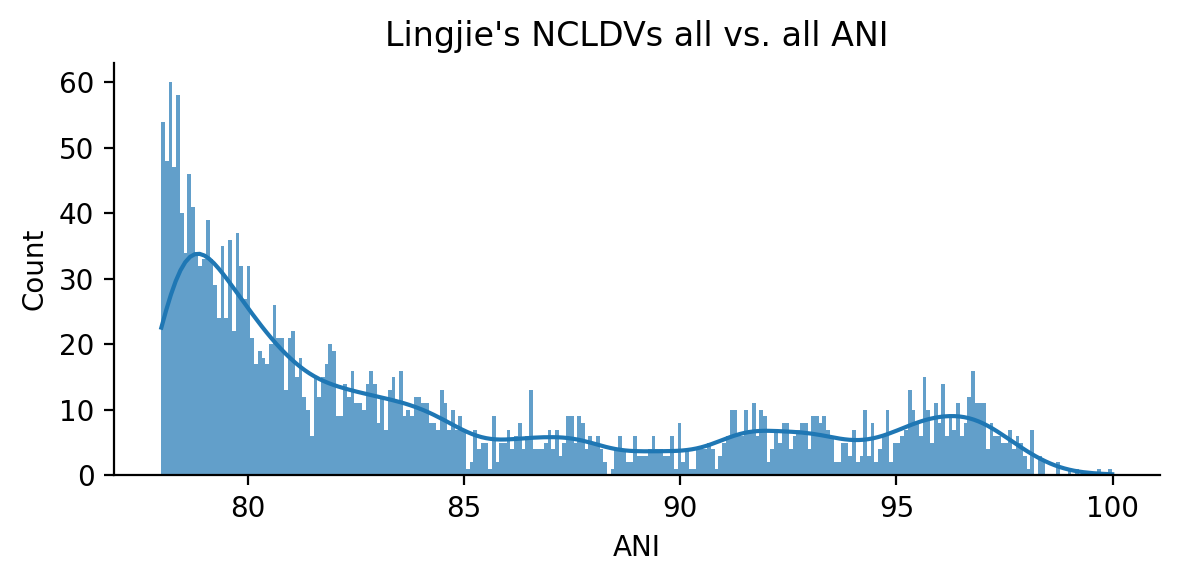

In [11]:
g = seaborn.displot( data=fastani[ ( fastani['ANI'] < max_ani )
                                 & ( fastani['ANI'] > 78 )
                                 & ( fastani['query_status'] == 'included' )
                                 & ( fastani['reference_status'] == 'included' )
                                 & ( fastani['bidirectional fragment mappings'] > 5 ) ],
                         x='ANI', kind='hist', kde=True, kde_kws={'bw_method':0.1}, bins=256,
                         fill=True, common_norm=False,
                         alpha=.7, linewidth=0, height=3, aspect=2)

title( 'Lingjie\'s NCLDVs all vs. all ANI' )
tight_layout()
savefig( 'figures/lingjie_ncldvs_ANI_distribution.png', facecolor='white', dpi=200 )

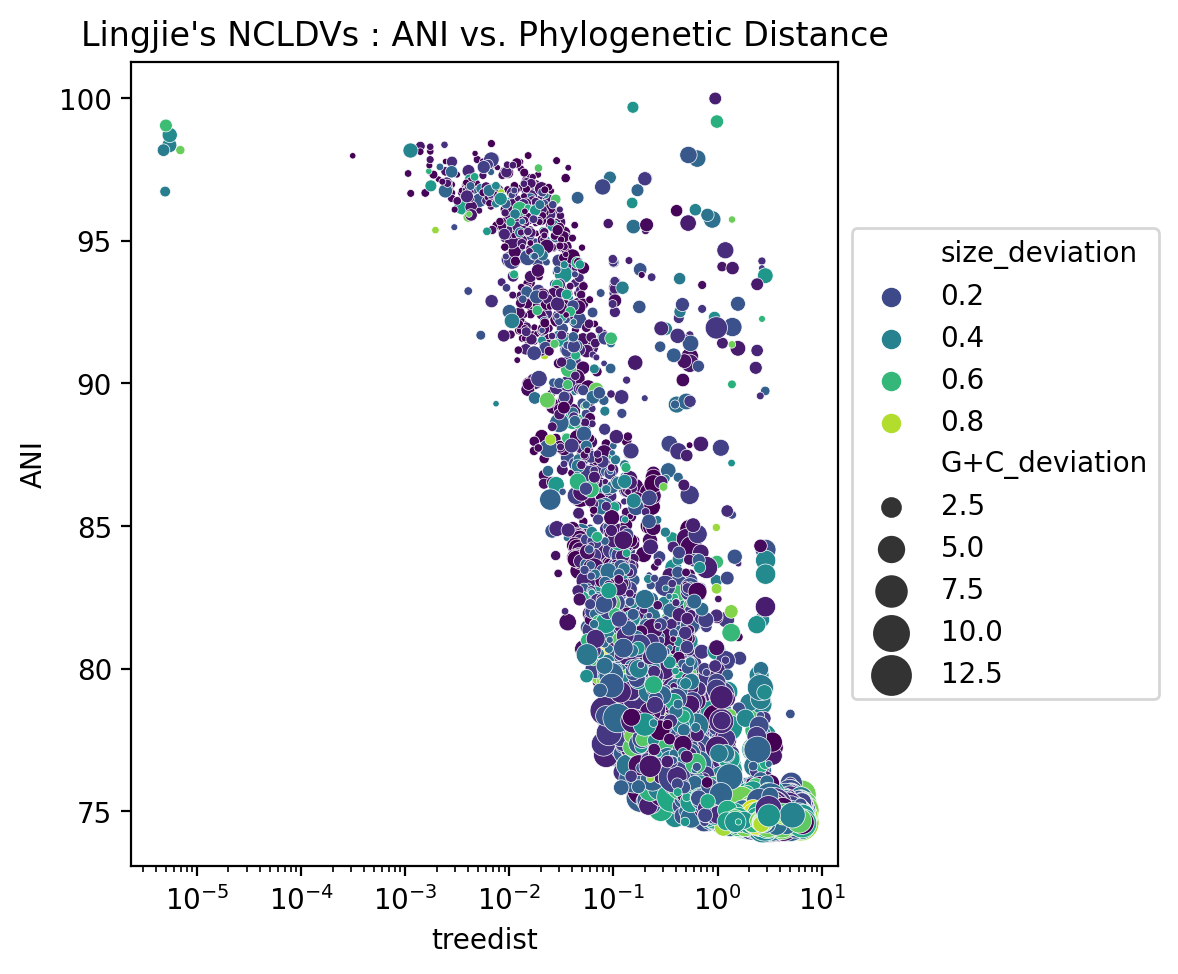

In [12]:
figure( figsize=(6,5) )

g = seaborn.scatterplot( data=fastani[ ( fastani['ANI'] < max_ani )
                                 & ( fastani['ANI'] > 70 )
                                 & ( fastani['query_status'] == 'included' )
                                 & ( fastani['reference_status'] == 'included' )
                                 #& ( fastani['treedist'] > 0.2 )
                                 & ( fastani['bidirectional fragment mappings'] > 10 ) ],
                         y='ANI', x='treedist', hue='size_deviation', size='G+C_deviation',
                         sizes=( 5, 200 ),
                         palette='viridis' )

g.legend( loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

semilogx()
title( 'Lingjie\'s NCLDVs : ANI vs. Phylogenetic Distance' )

tight_layout()
savefig( 'figures/lingjie_ncldvs_ANI_vs_treedist.png', facecolor='white', dpi=200 )

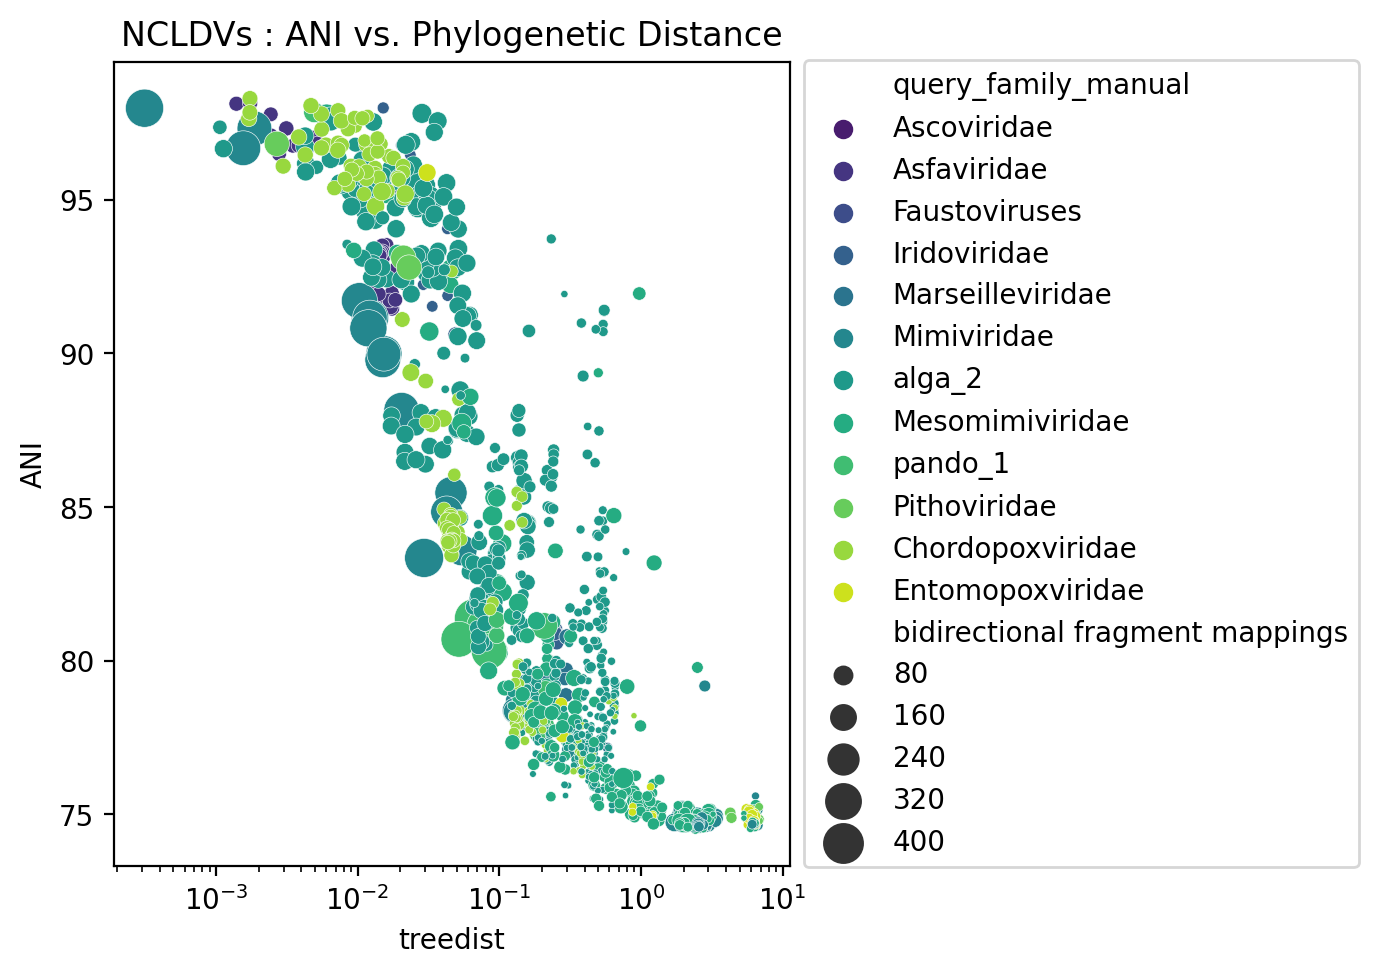

In [5]:
figure( figsize=(7,5) )

g = seaborn.scatterplot( data=fastani[ ( fastani['ANI'] < max_ani )
                                 & ( fastani['ANI'] > 70 )
                                 & ( fastani['query_status'] == 'included' )
                                 & ( fastani['reference_status'] == 'included' )
                                 #& ( fastani['treedist'] > 0.2 )
                                 & ( fastani['bidirectional fragment mappings'] > 1 )
                                 & ( fastani['query_checkv_quality'].isin( [ 'High-quality', 'Complete' ] ) )
                                 & ( fastani['reference_checkv_quality'].isin( [ 'High-quality', 'Complete' ] ) ) ],
                         y='ANI', x='treedist', hue='query_family_manual', size='bidirectional fragment mappings',
                         sizes=( 5, 200 ),
                         palette='viridis' )

g.legend( loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

semilogx()
title( 'NCLDVs : ANI vs. Phylogenetic Distance' )

tight_layout()
savefig( 'figures/lingjie_ncldvs_ANI_vs_treedist_checkv.png', facecolor='white', dpi=200 )

In [9]:
anomaly = fastani[ ( fastani['ANI'] < max_ani )
                 & ( fastani['ANI'] > 88 )
                 & ( fastani['query_status'] == 'included' )
                 & ( fastani['reference_status'] == 'included' )
                 & ( fastani['treedist'] > 0.2 )
                 & ( fastani['bidirectional fragment mappings'] > 1 ) ]

anomaly[ anomaly['treedist'] > 2.0 ][ ['query', 'reference', 'ANI', 'treedist',
                                       'bidirectional fragment mappings',
                                       'query_checkv_quality',
                                       'reference_checkv_quality'] ]

,query,reference,ANI,treedist,bidirectional fragment mappings,query_checkv_quality,reference_checkv_quality
2736,Moniruzzaman_MM01_ERX552270_62_dc,Moniruzzaman_MM12_ERX555958_4_dc,94.2909,2.669619,93,High-quality,Medium-quality
2737,Moniruzzaman_MM01_ERX552270_62_dc,TARA_AON_NCLDV_00003,94.0431,2.670174,84,High-quality,Medium-quality
2738,Moniruzzaman_MM01_ERX552270_62_dc,TARA_ARC_NCLDV_00124,92.2616,2.676270,24,High-quality,Low-quality
3354,Moniruzzaman_MM01_ERX552302_42_dc,Schulz_GVMAG_S_3300000115_70,91.1558,2.402257,26,Medium-quality,Medium-quality
3564,Moniruzzaman_MM01_ERX556037_25_dc,TARA_AON_NCLDV_00039,93.7771,2.875681,16,High-quality,Low-quality
3565,Moniruzzaman_MM01_ERX556037_25_dc,Schulz_GVMAG_M_3300023109_20,89.7376,2.873010,33,High-quality,Low-quality
3816,Moniruzzaman_MM01_SRX803008_24_dc,Schulz_GVMAG_S_3300000115_70,93.4764,2.403951,29,Medium-quality,Medium-quality
8908,Schulz_GVMAG_M_3300009076_8,TARA_ARC_NCLDV_00184,93.2359,2.900465,4,High-quality,Low-quality
9036,Schulz_GVMAG_M_3300009498_22,Schulz_GVMAG_S_1074258_71,90.5492,2.329095,12,Medium-quality,Low-quality
10254,Schulz_GVMAG_M_3300020182_10,Schulz_GVMAG_M_3300020187_12,89.5639,2.573813,35,Medium-quality,Medium-quality


Text(0.5, 1.0, "Lingjie's NCLDVs : ANI vs. Phylogenetic Distance")

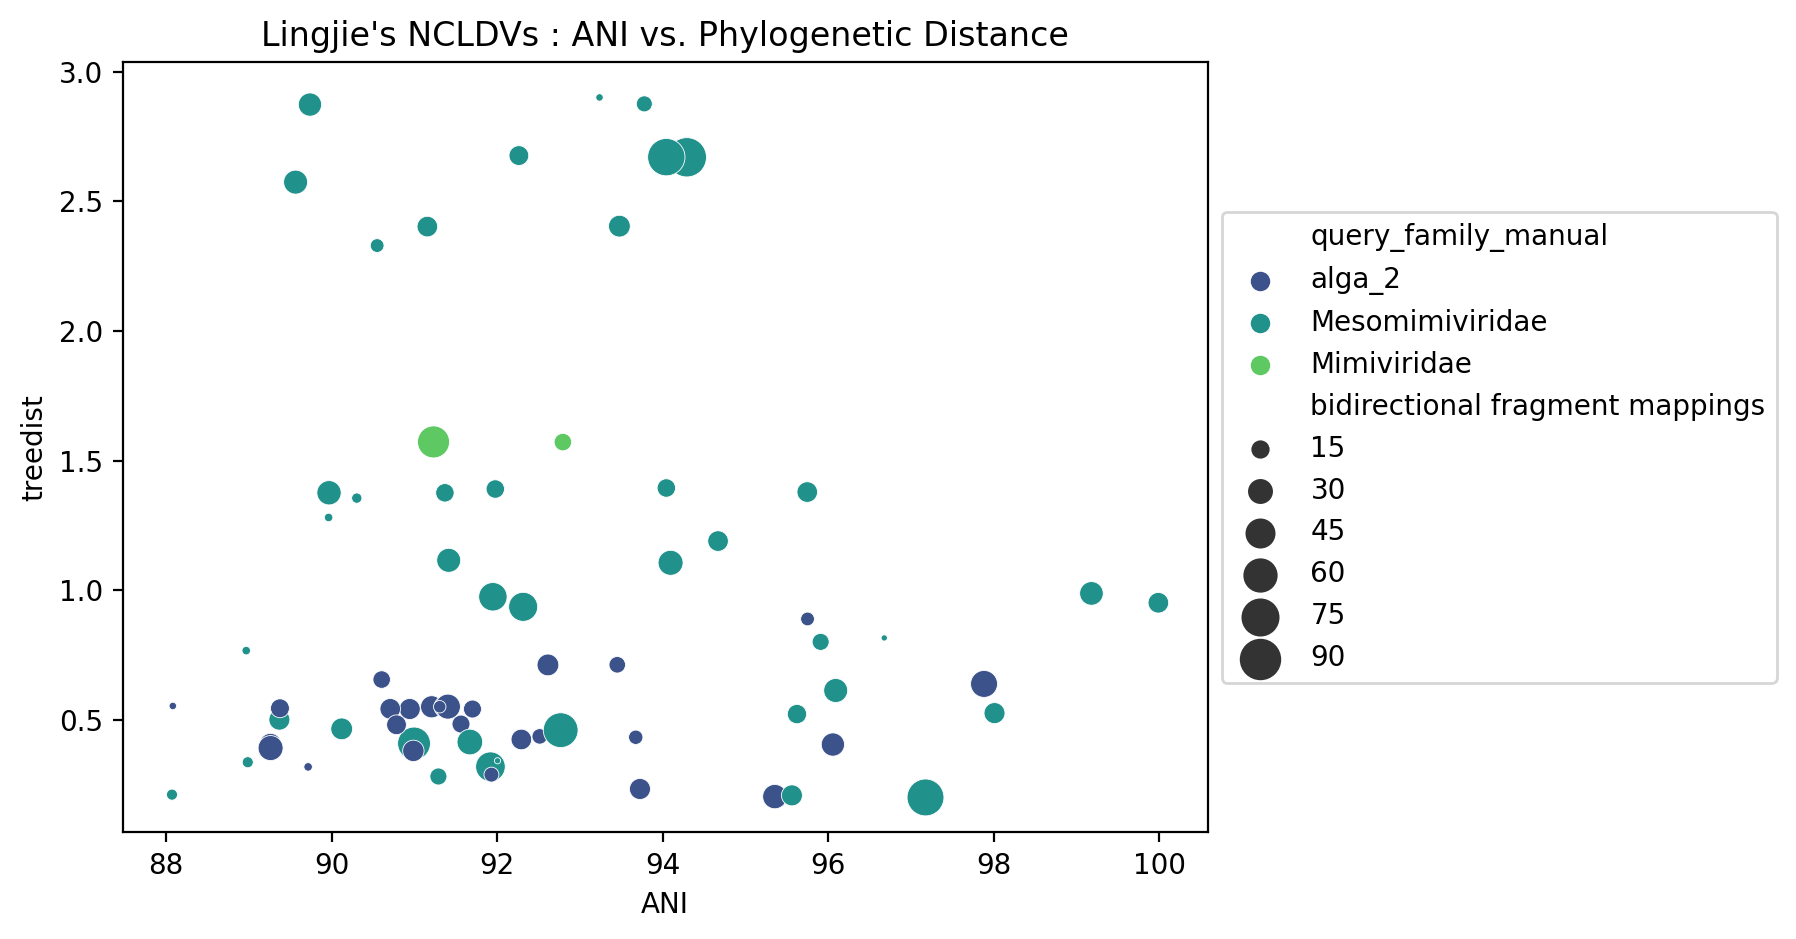

In [8]:
figure( figsize=(7,5) )

g = seaborn.scatterplot( data=anomaly,
                         x='ANI', y='treedist',
                         hue='query_family_manual', size='bidirectional fragment mappings',
                         sizes=( 5, 200 ),
                         palette='viridis' )

g.legend( loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

#axvspan( 89, 100, 0.5, 0.95, alpha=0.1 )

title( 'Lingjie\'s NCLDVs : ANI vs. Phylogenetic Distance' )

In [37]:
import csv
import numpy as np
from pathlib import Path

from Bio import SeqIO
from pygenomeviz import GenomeViz
from pygenomeviz.utils import ColorCycler



# Resource files for visualization

genome_fatat_file0 = Path( 'data/lingjie/anomaly/TARA_AON_NCLDV_00003.fa' )
fastani_visual_file10 = Path( 'data/lingjie/anomaly/2737.out.visual' )
genome_fasta_file1 = Path( 'data/lingjie/anomaly/Moniruzzaman_MM01_ERX552270_62_dc.fa' )
fastani_visual_file12 = Path( 'data/lingjie/anomaly/2736.out.visual' )
genome_fasta_file2 = Path( 'data/lingjie/anomaly/Moniruzzaman_MM12_ERX555958_4_dc.fa' )

COLORMAP = 'viridis'
LINK_COLOR = 'black'
CURVE = True

# Load genome fasta information
genome_name0 = genome_fasta_file0.with_suffix("").name
genome_name1 = genome_fasta_file1.with_suffix("").name
genome_name2 = genome_fasta_file2.with_suffix("").name
records0 = SeqIO.parse(genome_fasta_file0, "fasta")
contigs0 = [len(r) for r in records0]
seq_length0 = sum(contigs0)
records1 = SeqIO.parse(genome_fasta_file1, "fasta")
contigs1 = [len(r) for r in records1]
seq_length1 = sum(contigs1)
records2 = SeqIO.parse(genome_fasta_file2, "fasta")
contigs2 = [len(r) for r in records2]
seq_length2 = sum(contigs2)

# Load fastANI visual result
#for fastani_results10 = []
with open(fastani_visual_file10) as f:
    reader = csv.reader(f, delimiter="\t")
    for row in reader:
        start1, end1 = int(row[6]), int(row[7])
        start2, end2 = int(row[8]), int(row[9])
        identity = float(row[2])
        link1, link2 = (genome_name1, start1, end1), (genome_name2, start2, end2)
        fastani_results.append((link1, link2, identity))

# Visualize conserved regions detected by fastANI
gv = GenomeViz(
    fig_width=15,
    fig_track_height=1.0,
    feature_track_ratio=0.1,
    tick_track_ratio=0.2,
    align_type="center",  # "left", "center", "right"
    tick_style="bar",  # "axis", "bar", None
    plot_size_thr=0,
)

track1 = gv.add_feature_track(genome_name1, seq_length1)
track2 = gv.add_feature_track(genome_name2, seq_length2)

pos = 0
for i,color in zip( contigs1, ['#eeeeee', '#aaaaaa'] * len(contigs1) ) :
    track1.add_feature( pos, pos+i, 1, plotstyle='box', facecolor=color ) 
    pos = i+pos

pos = 0
for i,color in zip( contigs2, ['#eeeeee', '#aaaaaa'] * len(contigs2) ) :
    track2.add_feature( pos, pos+i, -1, plotstyle='box', facecolor=color ) 
    pos = i+pos

ColorCycler.set_cmap(COLORMAP)  # "hsv", "viridis", "jet", etc...
colormap, data_num = ColorCycler.cmap, len(fastani_results)
colors = [colormap(int(i)) for i in np.linspace(0, colormap.N, data_num)]

min_identity = int(min([res[2] for res in fastani_results]))
for res, color in zip(fastani_results, colors):
    link1, link2, identity = res
    track1.add_feature(link1[1], link1[2], -1, plotstyle="box", facecolor=color)
    track2.add_feature(link2[1], link2[2], 1, plotstyle="box", facecolor=color)
    gv.add_link(link1, link2, LINK_COLOR, v=identity, vmin=min_identity, curve=CURVE)

fig = gv.plotfig()

gv.set_colorbar(
    fig, bar_colors=[LINK_COLOR], vmin=min_identity, bar_height=0.3, bar_bottom=0.2
)

NameError: name 'genome_fasta_file0' is not defined

In [72]:
import tarfile
from functools import reduce

tb = tarfile.open( 'data/lingjie/lingjie_ncldvs.tar.gz', 'r' )
with open( 'data/lingjie/concatinated.fasta', 'w' ) as fout :
    for name in tb.getnames() :
        f = tb.extractfile( name )
        if name.endswith( '.fa' ) :
            taxon = path.split( name )[-1][:-3]
            concat = reduce( lambda a,b:a+b, [ rec for rec in SeqIO.parse( TextIOWrapper(f), 'fasta' ) ] )
            concat.id = taxon
            concat.description = ''
            fout.write( concat.format('fasta') )

In [108]:
fastani['within_genus'] = fastani.apply( lambda row : row['query_genus_manual'] == row['reference_genus_manual'], axis=1 )

In [130]:
checkv['checkv_quality'].value_counts()

Medium-quality    798
Low-quality       633
High-quality      324
Complete           61
Not-determined      1
Name: checkv_quality, dtype: int64

In [32]:
d_rejects = set( metadata[ metadata['Status'] != 'included' ]['Final_names'] )
q_rejects = set( contig.rsplit('_',1)[0] 
                 for contig in checkv[ checkv['checkv_quality'].isin([ 'Low-quality',
                                                                        'Medium-quality'
                                                                        'Undetermined' ]) ]['contig_id'] )

rejects = d_rejects | q_rejects

with open( 'data/lingjie/drop_taxa.txt', 'w' ) as f :
    f.write( '\n'.join( rejects ) )

In [31]:
import toytree

tt = toytree.tree( 'data/lingjie/mixture_concat.tree', tree_format=1 )
tt.draw()

(<toyplot.canvas.Canvas at 0x7f4530796440>,
 <toytree.Render.ToytreeMark at 0x7f452c5e6320>)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="500.0px" height="1000.0px" viewBox="0 0 500.0 1000.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tc7147cdeb33a403ea4af5ab855f78dbc"> <path d="M 107.9 571.2 L 107.9 571.5 L 10

In [9]:
toytree.mod.drop_tips( tt, [ node for node in tt.get_nodes() if node.name in droplist ], inplace=True )

#toytree.ToyTree.draw tt.draw( width=500, height=500, layout='u1', tip_labels=False )

AttributeError: module 'toytree' has no attribute 'mod'

In [48]:
header = ['query', 'reference', 'ANI', 'bidirectional fragment mappings', 'total query fragments' ]
simulated = pandas.read_csv( '/home/russell/pkg/Simulome/simulated_ecoli', sep='\t', names=header )

(array([ 6.,  4., 10., 14., 16., 11., 21., 13.,  6.,  5.,  1.,  1.,  2.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 11.]),
 array([ 85.5617    ,  85.67449922,  85.78729844,  85.90009766,
         86.01289687,  86.12569609,  86.23849531,  86.35129453,
         86.46409375,  86.57689297,  86.68969219,  86.80249141,
         86.91529062,  87.02808984,  87.14088906,  87.25368828,
         87.3664875 , 

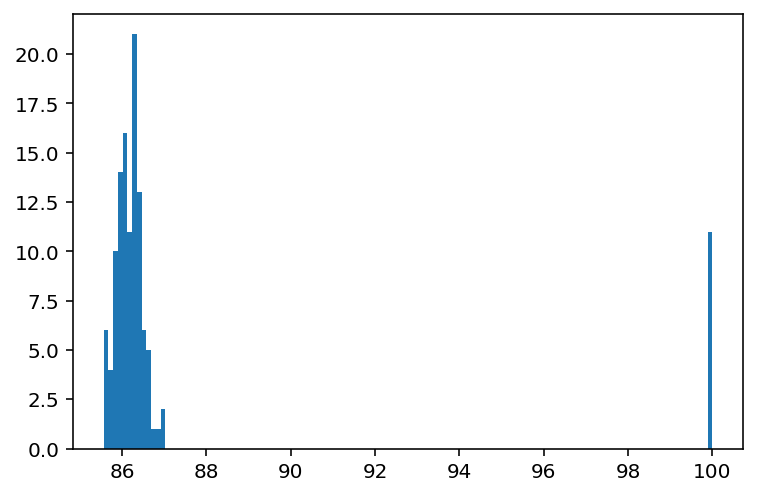

In [52]:
hist( simulated['ANI'], 128 )

In [13]:
genes = pandas.read_csv( 'data/lingjie/checkv_putput/tmp/gene_features.tsv', sep='\t' )

blast_cols = [ 'queryId', 'subjectId', 'percIdentity', 'alnLength', 
               'mismatchCount', 'gapOpenCount', 'queryStart', 'queryEnd',
               'subjectStart', 'subjectEnd', 'eVal', 'bitScore' ]

for n,rec in enumerate( parse( 'data/lingjie/concatinated.fasta', 'fasta' )  ) :
    print( genes[ genes['contig_id'] == rec.id ] )
    

                       contig_id  gene_num   start     end  strand    gc  \
0    Schulz_GVMAG_M_3300000115_3         1       3     245      -1  26.3   
1    Schulz_GVMAG_M_3300000115_3         2     332    1039       1  31.8   
2    Schulz_GVMAG_M_3300000115_3         3    1079    1558       1  36.9   
3    Schulz_GVMAG_M_3300000115_3         4    1604    2386       1  33.0   
4    Schulz_GVMAG_M_3300000115_3         5    2429    3361       1  28.4   
..                           ...       ...     ...     ...     ...   ...   
205  Schulz_GVMAG_M_3300000115_3       206  197152  197349      -1  32.3   
206  Schulz_GVMAG_M_3300000115_3       207  197422  198774       1  35.0   
207  Schulz_GVMAG_M_3300000115_3       208  198811  199983       1  30.8   
208  Schulz_GVMAG_M_3300000115_3       209  199984  200223      -1  37.9   
209  Schulz_GVMAG_M_3300000115_3       210  200306  201316       1  36.7   

     hmm_cat  hmm_db      hmm_name        evalue  score  
0          0     NaN         

,Final_names,Ancient_names,Source,Status,Realm,Phylum,Class,Order,Family_Linking_to_GVDB,Family_manual,...,gu_c_121,k_c_82,k_c_51,gu_c_37,gu_c_168,gu_c_55,k_c_55,gu_c_18,Nb_Histones,Nb_Rhodopsins
0,Acanthamoeba_castellanii_medusavirus,Acanthamoeba_castellanii_medusavirus,Reference,Taxon_sampling,Varidnaviria,Nucleocytoviricota,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,3.0,NaN
1,Ascoviridae_CU469068_Complete_DpAV4,Ascoviridae_CU469068_Complete_DpAV4,Reference,included,Varidnaviria,Nucleocytoviricota,Megaviricetes,Pimascovirales,PM_02,Ascoviridae,...,0,0,0,0,0,0,0,0,NaN,NaN
2,Ascoviridae_DQ517337_Trichoplusia_ni_ascovirus_2c,Ascoviridae_DQ517337_Trichoplusia_ni_ascovirus_2c,Reference,included,Varidnaviria,Nucleocytoviricota,Megaviricetes,Pimascovirales,PM_02,Ascoviridae,...,0,1,0,0,0,0,0,0,NaN,NaN
3,Ascoviridae_EF133465_Heliothis_virescens_ascov...,Ascoviridae_EF133465_Heliothis_virescens_ascov...,Reference,included,Varidnaviria,Nucleocytoviricota,Megaviricetes,Pimascovirales,PM_02,Ascoviridae,...,0,1,0,0,0,0,0,0,NaN,NaN
4,Ascoviridae_KJ755191_Heliothis_virescens_ascov...,Ascoviridae_KJ755191_Heliothis_virescens_ascov...,Reference,included,Varidnaviria,Nucleocytoviricota,Megaviricetes,Pimascovirales,PM_02,Ascoviridae,...,0,1,0,0,0,0,0,0,NaN,NaN


In [51]:
taxlevel = { 'domain'  : 'd__',
             'phylum'  : 'p__', 
             'class'   : 'c__',
             'order'   : 'o__',
             'family'  : 'f__',
             'genus'   : 'g__',
             'species' : 's__', }

taxmap = { 'Realm'         : 'domain',
           'Phylum'        : 'phylum',
           'Class'         : 'class',
           'Order'         : 'order',
           'Family_manual' : 'family',
           'Genus_manual'  : 'genus', }

with open( 'data/lingjie/taxonomy.tsv', 'w' ) as f :
    for n,row in goev[ goev['Status'] == 'included' ].iterrows() :
        taxon = []
        for key,value in taxmap.items() :
            if pandas.isna( row[key] ) :
                taxon.append( taxlevel[value] )
            else :
                taxon.append( taxlevel[value] + row[key] )
        taxon.append( 's__' )
        f.write( row['Final_names'] + '\t' + ';'.join(taxon) + '\n' )

In [52]:
taxonomy = pandas.read_csv( 'data/lingjie/taxonomy.tsv', sep='\t',
                            names=['genome','taxon'], na_values=['NA','Na'] )
taxonomy.head()

,genome,taxon
0,Ascoviridae_CU469068_Complete_DpAV4,d__Varidnaviria;p__Nucleocytoviricota;c__Megav...
1,Ascoviridae_DQ517337_Trichoplusia_ni_ascovirus_2c,d__Varidnaviria;p__Nucleocytoviricota;c__Megav...
2,Ascoviridae_EF133465_Heliothis_virescens_ascov...,d__Varidnaviria;p__Nucleocytoviricota;c__Megav...
3,Ascoviridae_KJ755191_Heliothis_virescens_ascov...,d__Varidnaviria;p__Nucleocytoviricota;c__Megav...
4,Ascoviridae_NC_008361_Spodoptera_frugiperda_as...,d__Varidnaviria;p__Nucleocytoviricota;c__Megav...


In [53]:
taxonomy[ taxonomy['genome'] == 'Acanthamoeba_castellanii_medusavirus' ]

,genome,taxon


In [80]:
import dendropy

T = dendropy.Tree.get_from_path( 'data/lingjie/Mixture.Conca4.2ndRound.treefile',
                                 schema='newick', preserve_underscores=True )
print( '{nodes} nodes, {leafs} leafs before trimming'.format( nodes=len(T.internal_nodes()),
                                                              leafs=len(T.leaf_nodes()) ) ) 
T.prune_taxa_with_labels( list( goev[ goev['Status'] != 'included' ]['Final_names'] ) )
print( '{nodes} nodes, {leafs} leafs after trimming'.format( nodes=len(T.internal_nodes()),
                                                             leafs=len(T.leaf_nodes()) ) )
T.write_to_path( 'data/lingjie/mixture_concat.tree',
                 schema='newick' )

1754 nodes, 1756 leafs before trimming
1721 nodes, 1722 leafs after trimming


In [82]:
!phylorank decorate data/lingjie/mixture_concat.tree data/lingjie/taxonomy.tsv data/lingjie/mixture_concat_decorated.tree

[2022-11-16 17:10:42] INFO: PhyloRank v0.1.11
[2022-11-16 17:10:42] INFO: phylorank decorate data/lingjie/mixture_concat.tree data/lingjie/taxonomy.tsv data/lingjie/mixture_concat_decorated.tree
[2022-11-16 17:10:42] INFO: Reading tree.
[2022-11-16 17:10:42] INFO: Removing any previous internal node labels.
[2022-11-16 17:10:42] INFO: Reading taxonomy.
[2022-11-16 17:10:42] INFO: Calculating F-measure statistic for each taxa.
[2022-11-16 17:10:42] INFO: Calculating taxa within each lineage.
[2022-11-16 17:10:42] INFO: Processing 2 taxa at Domain rank.
 - processed 2 of 2 (100.00%) taxa.                                                   
 - elapsed time: 0.00 minutes
[2022-11-16 17:10:42] INFO: Processing 2 taxa at Phylum rank.
 - processed 2 of 2 (100.00%) taxa.                                                   
 - elapsed time: 0.00 minutes
[2022-11-16 17:10:42] INFO: Processing 10 taxa at Class rank.
 - processed 10 of 10 (100.00%) taxa.                                               

In [83]:
pandas.read_csv( 'data/lingjie/mixture_concat_decorated.tree-summary', sep='\t' )

,Rank,No. taxon,No. monophyletic,No. operationally monophyletic,No. polyphyletic,Monophyletic (%),Operationally monophyletic (%),Polyphyletic (%)
0,domain,2,2,0,0,100.000,0.000,0.000
1,phylum,2,2,0,0,100.000,0.000,0.000
2,class,10,10,0,0,100.000,0.000,0.000
3,order,14,14,0,0,100.000,0.000,0.000
4,family,18,13,2,3,72.222,11.111,16.667
5,genus,24,20,4,0,83.333,16.667,0.000


In [84]:
pandas.read_csv( 'data/lingjie/mixture_concat_decorated.tree-table', sep='\t')

,Taxon,No. Expected in Tree,F-measure,Precision,Recall,No. Genomes from Taxon,No. Genome In Lineage,Rogue out,Rogue in
0,d__Duplodnaviria,110,1.0,1.0,1.0,110,110,NaN,NaN
1,d__Varidnaviria,1612,1.0,1.0,1.0,1612,1612,NaN,NaN
2,p__Mirusviricota,110,1.0,1.0,1.0,110,110,NaN,NaN
3,p__Nucleocytoviricota,1612,1.0,1.0,1.0,1612,1612,NaN,NaN
4,c__MR_01,42,1.0,1.0,1.0,42,42,NaN,NaN
...,...,...,...,...,...,...,...,...,...
65,g__meso_5_D2,53,1.0,1.0,1.0,53,53,NaN,NaN
66,g__mimi_3_A,22,1.0,1.0,1.0,22,22,NaN,NaN
67,g__mimi_3_B,14,1.0,1.0,1.0,14,14,NaN,NaN
68,g__mimi_4_A,34,1.0,1.0,1.0,34,34,NaN,NaN


In [28]:
pandas.read_csv( 'data/lingjie/mixture_concat_decorated.tree-taxonomy', sep='\t' )

,Ascoviridae_CU469068_Complete_DpAV4,d__Varidnaviria; p__Nucleocytoviricota; c__Megaviricetes; o__Pimascovirales; f__Iridoviridae; f__Ascoviridae; g__; s__
0,Ascoviridae_DQ517337_Trichoplusia_ni_ascovirus_2c,d__Varidnaviria; p__Nucleocytoviricota; c__Meg...
1,Ascoviridae_EF133465_Heliothis_virescens_ascov...,d__Varidnaviria; p__Nucleocytoviricota; c__Meg...
2,Ascoviridae_KJ755191_Heliothis_virescens_ascov...,d__Varidnaviria; p__Nucleocytoviricota; c__Meg...
3,Ascoviridae_NC_008361_Spodoptera_frugiperda_as...,d__Varidnaviria; p__Nucleocytoviricota; c__Meg...
4,Iridoviridae_AF303741_Chilo_iridescent_virus,d__Varidnaviria; p__Nucleocytoviricota; c__Meg...
...,...,...
1716,TARA_PSW_NCLDV_00083,d__Duplodnaviria; p__Mirusviricota; c__MR_04; ...
1717,TARA_MED_NCLDV_00076,d__Duplodnaviria; p__Mirusviricota; c__MR_04; ...
1718,TARA_PSW_NCLDV_00061,d__Duplodnaviria; p__Mirusviricota; c__MR_04; ...
1719,TARA_ARC_NCLDV_00150,d__Duplodnaviria; p__Mirusviricota; c__MR_06; ...


In [46]:
import dendropy

T = dendropy.Tree.get_from_path( 'data/lingjie/mixture_concat_decorated.tree',
                                 schema='newick', preserve_underscores=True )
for node in T.nodes() :
    if node.annotations :
        print( node.annotations )

In [93]:
#for node in T.internal_nodes() :
#    if node.label :
#        print( node.label, node.leaf_nodes() )

taxonomy2leaf = { node.label : [ leaf.taxon.label for leaf in node.leaf_iter() ] 
                  for node in T.internal_nodes() if node.label }

taxlevel = { 'd' : 'domain',
             'p' : 'phylum', 
             'c' : 'class',
             'o' : 'order',
             'f' : 'family',
             'g' : 'genus',
             's' : 'species', }

def transtax( a, b ) :
    parent = T.mrca( taxon_labels=[ a, b ] )
    while not parent.label :
        parent = parent.parent_node
        if not parent :
            return 'root'
    return taxlevel[ parent.label.split('__')[0] ]
    
pairtax = { frozenset( ( a, b ) ) : transtax( a, b ) 
            for a,b in combinations( [ leaf.taxon.label for leaf in T.leaf_nodes() ], 2 ) }

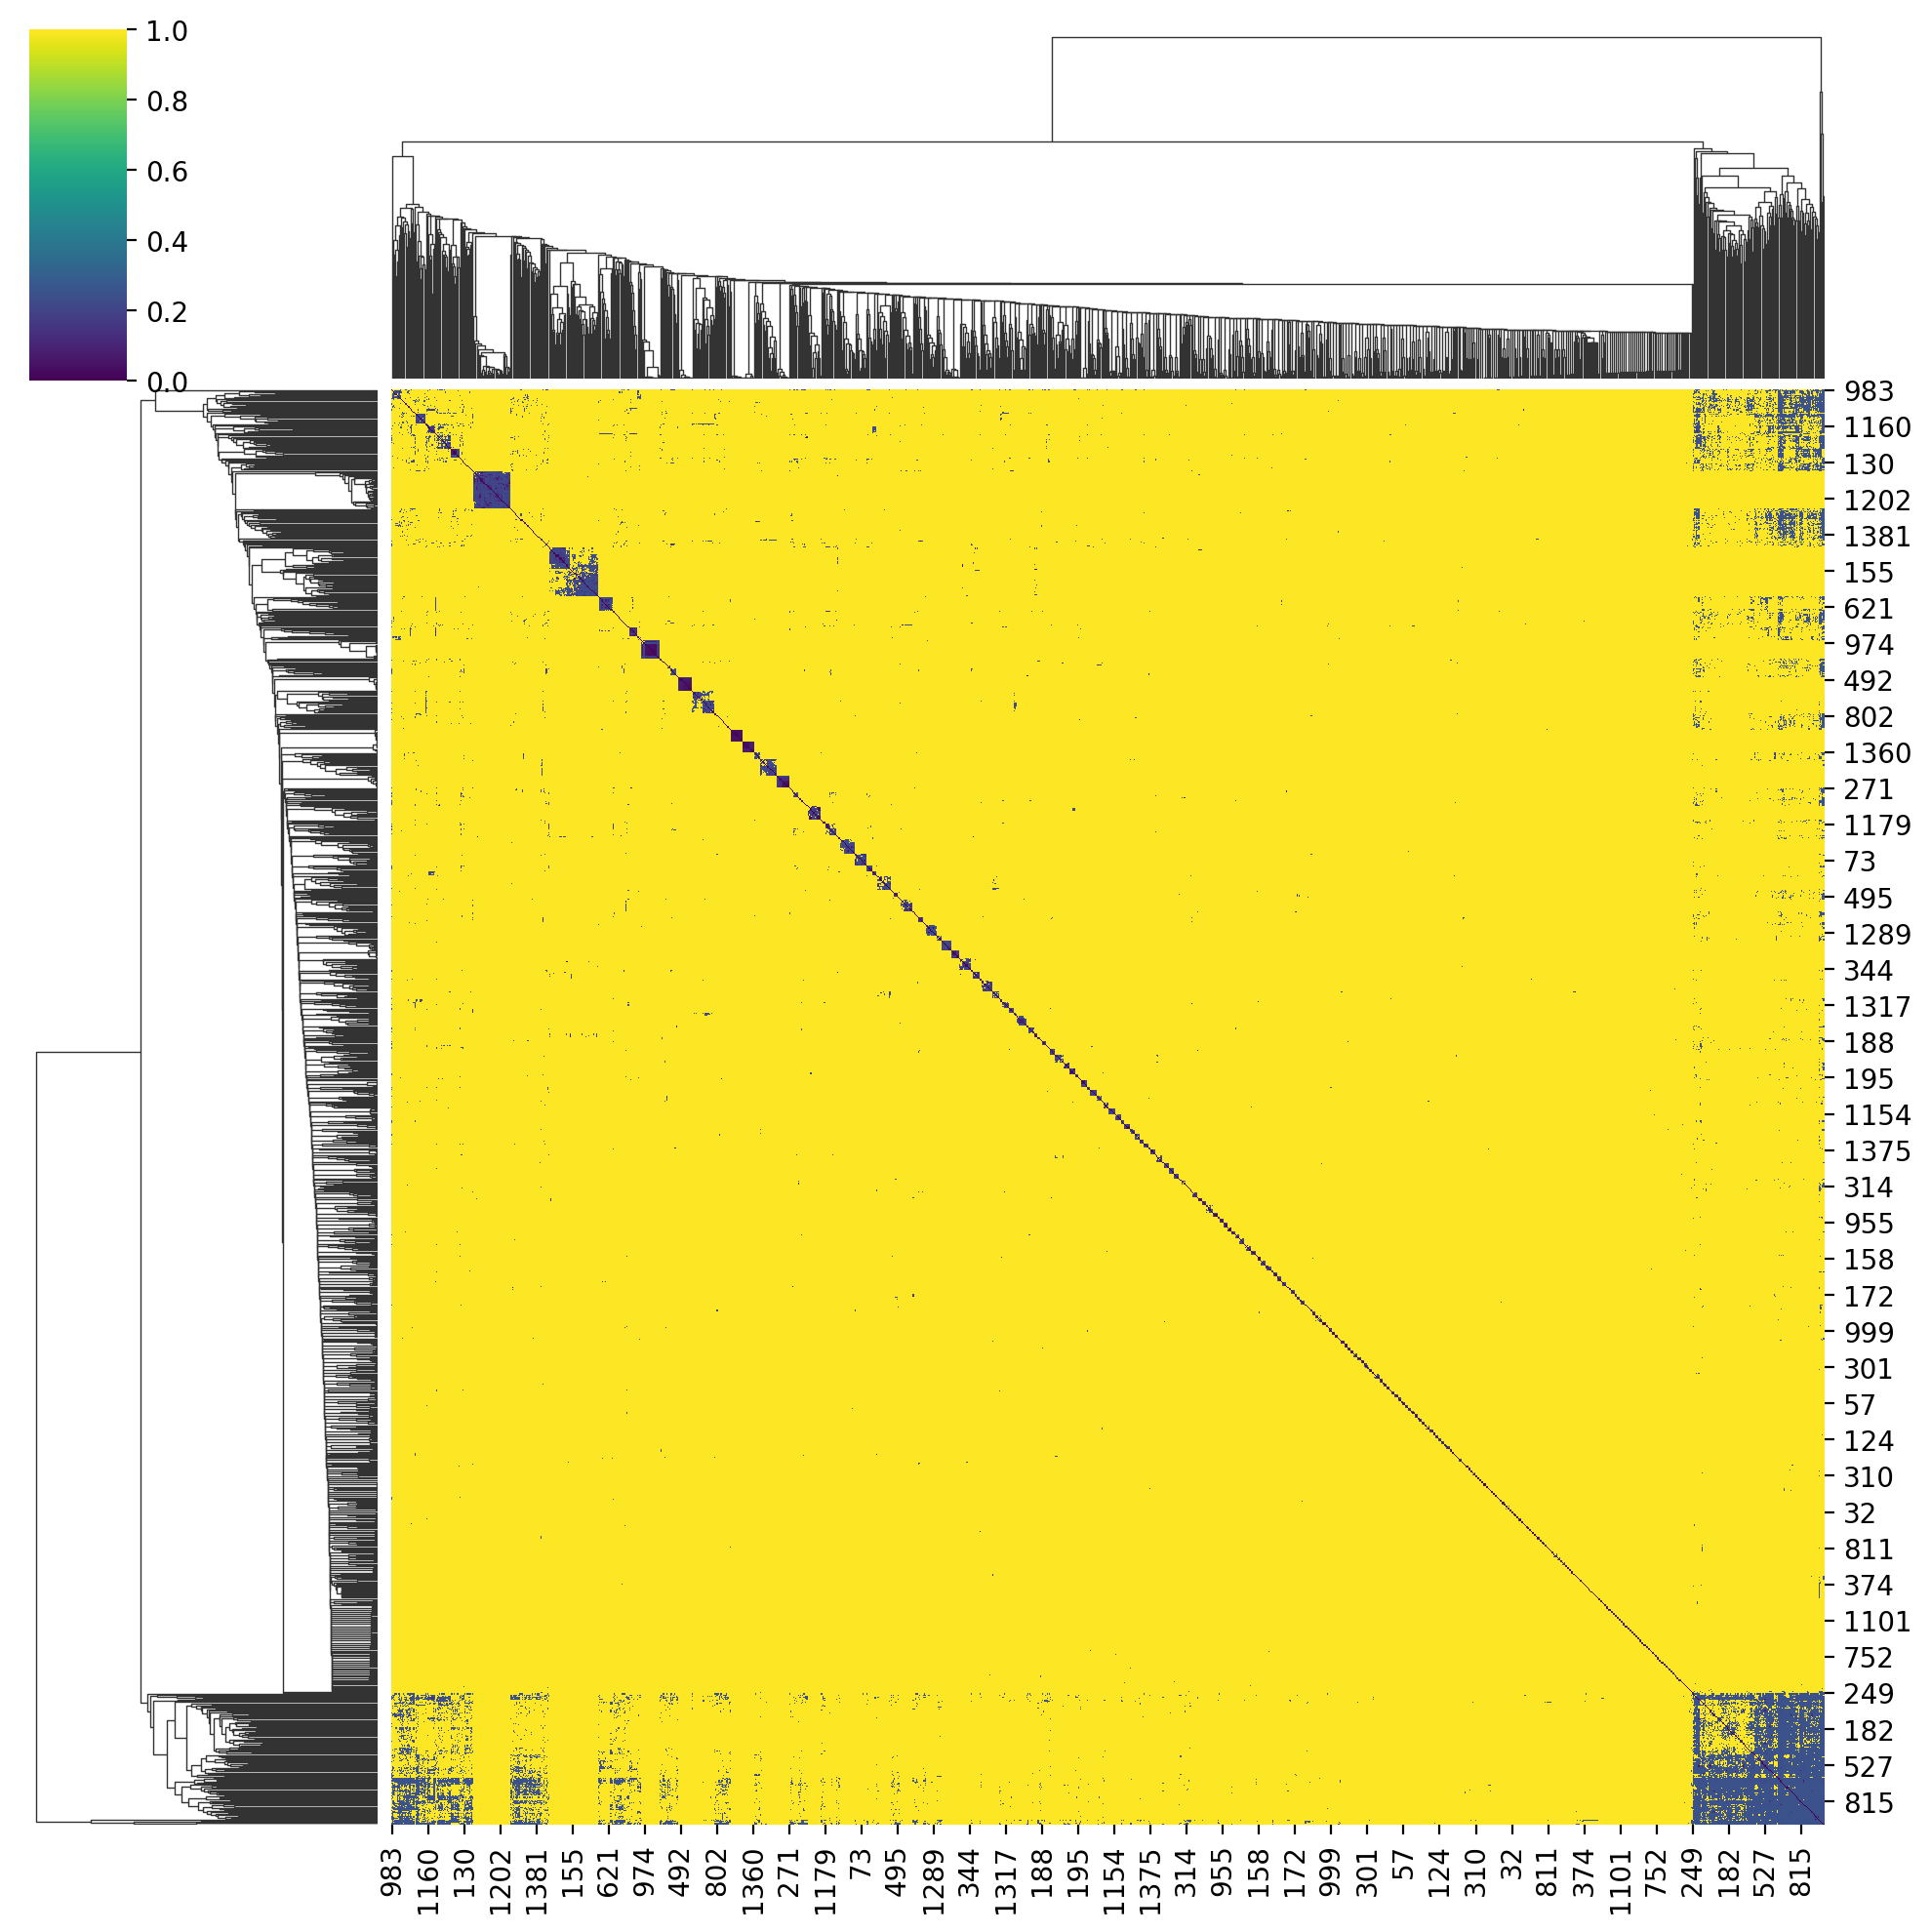

In [55]:
genomes = list( set( fastani['query'] ) | set( fastani['reference'] ) )
D = zeros( ( len(genomes), len(genomes) ) )
D.fill( 1.0 )
for i in range(len(genomes)) :
    D[i,i] = 0.0
for n,row in fastani.iterrows() :
    i = genomes.index( row['query'] )
    j = genomes.index( row['reference'] )
    D[i,j] = D[j,i] = 1.0 - row['ANI']/100
    
seaborn.clustermap(D, cmap='viridis')

In [82]:
from scipy.cluster.hierarchy import single, average, complete, ward, fcluster
from scipy.spatial.distance import squareform

clusters = defaultdict(list)
for n,c in enumerate( fcluster( single( squareform(D) ), 0.07, criterion='distance' ) ) :
    clusters[c].append( genomes[n] )
clusters

defaultdict(list,
            {868: ['TARA_MED_NCLDV_00045'],
             370: ['TARA_AON_NCLDV_00049'],
             365: ['Moniruzzaman_MM12_ERX552270_116_dc'],
             585: ['Schulz_GVMAG_M_3300017956_3'],
             364: ['Phycodnaviridae_KX857749_Only_Syngen_Nebraska_virus_5'],
             360: ['TARA_ARC_NCLDV_00111',
              'Moniruzzaman_MM12_ERX552261_23_dc'],
             358: ['TARA_AON_NCLDV_00067'],
             729: ['Moniruzzaman_MM01_ERX556031_42_dc'],
             524: ['Schulz_GVMAG_S_ERX556088_21'],
             1140: ['Moniruzzaman_MM09_ERX552270_76_dc'],
             917: ['Schulz_GVMAG_S_1102105_81',
              'Schulz_GVMAG_M_3300024261_78'],
             357: ['Moniruzzaman_MM01_ERX552255_28_dc'],
             353: ['TARA_PSW_NCLDV_00087'],
             558: ['TARA_MED_NCLDV_00002'],
             1086: ['Schulz_GVMAG_M_3300024261_71'],
             351: ['Schulz_GVMAG_M_3300020187_94'],
             515: ['Mimiviridae_JN885990_Megavirus_courdo7

In [61]:
unique?